# ⭐ Method 1: Favorite
This method saves intermediate outputs to a list that is returned in the module's `forward()` function. Since the list is returned, rather than saved as a property of the model, I don't need to define a separate model (that is, create a new model object) for the Style, Content, and Generated images.

This method applies 5 intermediate outputs to _both_ the Content and the Styles. By far, it produces the most beautiful results of the three methods attempted here.

This method comes primarily from the YouTube video starred below, though I made a few modifications, including allowing images of arbitrary size (as long as the style and content images have the same dimensions).

## Notes: helpful resources

---
Try this first: create my own network, from scratch (not using the code cells below), following the video tutorial. Adjust it so I can upload any size image (remove the fully-connected layers at the end). Somehow freeze the parameters (loop through model.parameters and apply `requires_grad = False`?). Test on larger image to see if it works.

---

4-Feb-2022

The following resources were helpful to me as I researched to understand how to implement this style transfer technique using the PyTorch framework:
* ⭐ [YouTube video walkthrough (24min)](https://www.youtube.com/watch?v=imX4kSKDY7s), accomplishes exactly the task that we are trying to do in this lab. The video author explains concepts clearly and teaches why each part of code is used.
* ⭐ [Helpful blog article on using forward hooks in PyTorch](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html). The author also teaches how to set up a DataLoader object in PyTorch and how to load data from a `pandas` DataFrame (with data from a .csv file). Explains how to create helper functions to capture output and use those functions with `module.register_forward_hook(helper_function)`. "A hook is simply a command that is executed when a forward or backward call to a certain layer is performed. If you want to know more about hooks, you can check out [this link](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/)."


**Other resources**

These resources helped me understand alternative approaches to using hooks, including re-writing `nn.Module`s and creating custom `def forward` functions with multiple outputs (say, the final output plus a dictionary with outputs from prior steps). These resources don't provide the best solutions, but they helped me understand the PyTorch framework better. I found these resources by Googling "pytorch get intermediate output from sequential".
* [Overview of different methods to get activations from intermediate layers](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/#method-3-attach-a-hook)
* [torchsummary](https://github.com/sksq96/pytorch-summary), package for viewing model dimensions (not related to hooks, but shows the layers of the network). Note: might be called [torchinfo](https://github.com/TylerYep/torchinfo) now.
* [How to tell PyTorch not to compute gradients](https://stackoverflow.com/questions/51748138/pytorch-how-to-set-requires-grad-false) for parameters (network layers) using `parameter.requires_grad = False`
 - See also: [Notebook with examples](https://github.com/MeiqiGuo/PytorchLearningNotes/blob/master/NoGrad.ipynb), [Forum article on Fast.AI](https://forums.fast.ai/t/pytorch-best-way-to-get-at-intermediate-layers-in-vgg-and-resnet/5707), [PyTorch forum article](https://discuss.pytorch.org/t/model-train-and-requires-grad/25845)
* [PyTorch docs on Module hooks](https://pytorch.org/docs/stable/notes/modules.html#module-hooks)
* [PyTorch forum on extracting intermediate layer activations](https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3)
* [GitHub issue (Q&A?) on getting intermediate outputs](https://github.com/pytorch/vision/issues/1896)
* Similar technique to GitHub issue above, [StackOverflow response using a custom `forward()` method](https://stackoverflow.com/questions/63427771/extracting-intermediate-layer-outputs-of-a-cnn-in-pytorch)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import requests

In [ ]:
# View the model layers (and position of each layer)
print(torchvision.models.vgg16(pretrained=True).features)

# List the layers to be used for output capture
# In the paper, layers used are the convolutional layers that follow pooling
# conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1
['0', '5', '10', '17', '24']

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

['0', '5', '10', '17', '24']

In [ ]:
# Create a custom class for the network
class VGG(nn.Module):
    def __init__(self):
        # Inherit from main class
        super().__init__()
        # Store features from which outputs will be collected
        self.chosen_features = ['0', '5', '10', '17', '24']
        # Include only the layers up to the one we need; we don't need any later layers
        self.model = torchvision.models.vgg16(pretrained=True).features[:25]
    
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

# Set device for PyTorch (cpu or cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a model object, use .eval() to tell PyTorch to handle BatchNorm and Dropout in evaluation (not training) mode
model = VGG().to(device).eval()

style_img = Image.open(BytesIO(requests.get('https://images.unsplash.com/photo-1643634253140-56872e2f2fa3').content))
style_img = style_img.resize(size=(800,1000))
content_img = Image.open(BytesIO(requests.get('https://images.unsplash.com/photo-1511527661048-7fe73d85e9a4').content))
content_img = content_img.resize(size=(800,1000))

# Function to load images to tensors
img_to_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Note that ToTensor accepts both PIL images and numpy ndarrays
style_tensor = img_to_tensor(style_img).unsqueeze(0).to(device)
content_tensor = img_to_tensor(content_img).unsqueeze(0).to(device)
generated_tensor = content_tensor.clone().requires_grad_(True)

In [ ]:
# Set hyperparameters
total_steps = 100
learning_rate = 0.1
content_weight = 0.001
style_weight = 1.0

optimizer = torch.optim.Adam([generated_tensor], lr=learning_rate)

with torch.no_grad():
    content_features = model(content_tensor)
    style_features = model(style_tensor)

progress_bar = tqdm(total=total_steps)

for step in range(total_steps):
    generated_features = model(generated_tensor)

    style_loss = 0
    content_loss = 0

    for gen_feature, cont_feature, style_feature in zip(generated_features, content_features, style_features):
        batch_size, channel, height, width = gen_feature.shape
        # Increase the content loss
        content_loss += torch.mean((gen_feature - cont_feature) ** 2)

        # Gram matrix
        # The feature channels are matrix-multiplied (.mm) with a transposed version of themselves
        gram_gen = gen_feature.view(channel, height * width).mm(
                   gen_feature.view(channel, height * width).t())
        gram_style = style_feature.view(channel, height * width).mm(
                     style_feature.view(channel, height * width).t())
        style_loss += torch.mean((gram_gen - gram_style) ** 2)
    
    total_loss = (content_weight * content_loss) + (style_weight * style_loss)
    progress_bar.set_description(f'{step+1}/{total_steps}, Total loss: {total_loss.item():,.0f}, Content loss: {content_loss.item():,.0f}, Style loss: {style_loss.item():,.0f}')
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    progress_bar.update(n=1)

    if step % 10 == 0:
        torchvision.utils.save_image(generated_tensor, f"generated_img_{step}.png")

  0%|          | 0/100 [00:00<?, ?it/s]

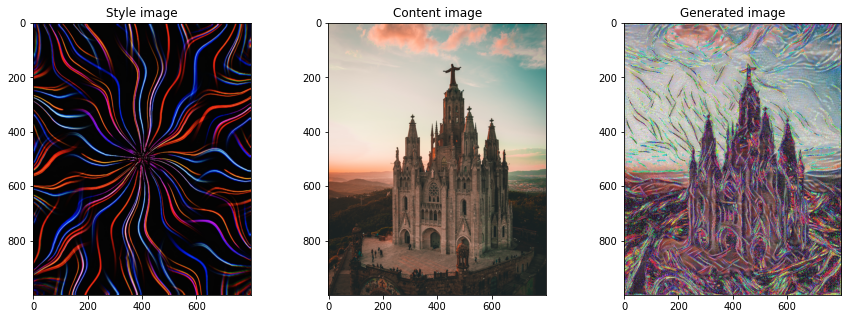

In [ ]:
# Show the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(style_img)
plt.title('Style image')

plt.subplot(1, 3, 2)
plt.imshow(content_img)
plt.title('Content image')

# Custom function to transform a tensor to a Pillow image
toPIL = torchvision.transforms.ToPILImage()

plt.subplot(1, 3, 3)
plt.imshow(toPIL(generated_tensor.detach().cpu().clone().squeeze(0)))
plt.title('Generated image')

plt.show()

Display plots using saved images

In [ ]:
# import matplotlib.pyplot as plt
# from PIL import Image
# # Show the images
plt.figure(figsize=(15, 5), dpi=300)

plt.subplot(1, 3, 1)
plt.imshow(Image.open('Style_img.png'))
plt.title('Style image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open('Content_img.png'))
plt.title('Content image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open('generated_img_90.png'))
plt.title('Generated image')
plt.axis('off')

plt.show()

Create a .gif from the saved images

In [1]:
# Save a gif image
# See: https://github.com/maxhumber/gif
# !pip install gif
import matplotlib.pyplot as plt
from PIL import Image
import gif

@gif.frame
def one_frame(filepath):
    plt.figure(figsize=(4, 5), dpi=150)
    plt.title(filepath[:-4].replace('_', ' ').title())
    plt.axis('off')
    plt.imshow(Image.open(filepath))

frames = []
for item in ['Style_img.png', 'Content_img.png', 'generated_img_0.png',
             'generated_img_10.png', 'generated_img_20.png', 'generated_img_30.png',
             'generated_img_40.png', 'generated_img_50.png', 'generated_img_60.png',
             'generated_img_70.png', 'generated_img_80.png', 'generated_img_90.png',
             'generated_img_99.png']:
    x = one_frame(item)
    frames.append(x)

gif.save(frames, 'Style_transfer.gif', duration=15.0, unit="s", between="startend")

In [ ]:
num_params = sum([torch.numel(layer) for layer in model.parameters()])
print(f'{num_params:,d}')

9,995,072


# Method 2
A blend of Method 1 (above) and Method 3 (below).

Specifically, this method uses `register_forward_hook` within the module class to capture the intermediate outputs, and it uses only 1 content output along with 5 style outputs.

Picture sources:
* Style image: [Photo](https://unsplash.com/photos/b_xKZWwRz60) by [Eugene Golovesov](https://unsplash.com/@eugene_golovesov) on Unsplash
* Content image: [Photo](https://unsplash.com/photos/d0xjEv-WJQk) by [Biel Morro](https://unsplash.com/@bielmorro) on Unsplash

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils

import numpy as np
import matplotlib.pyplot as plt

# tqdm creates progress bars
from tqdm.notebook import tqdm

# Pillow is for manipulating images
from PIL import Image
# io is for processing input (e.g., io.BytesIO(img_bytes__from_url))
import io

# The lines below help manage GPU memory
# garbage collector
import gc
# format tracebacks (exceptions)
from IPython.core.ultratb import AutoFormattedTB
# create a variable (__ITB__) to capture exceptions
__ITB__ = AutoFormattedTB(mode='Verbose', color_scheme='LightBg', tb_offset=1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
import torch
import torch.nn as nn
import torchvision

# For making web requests
import requests
# For processing bytes data (images)
from io import BytesIO
# For working with images
from PIL import Image
# For displaying images
import matplotlib.pyplot as plt

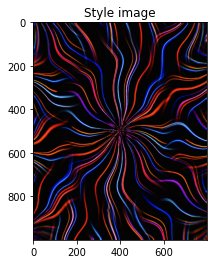

In [ ]:
style_img = Image.open(BytesIO(requests.get('https://images.unsplash.com/photo-1643634253140-56872e2f2fa3').content))
# Crop to 800 x 1000 (w x h)
# img_width, img_height = style_img.size
# left = (img_width // 2) - 400
# right = (img_width // 2) + 400
# upper = (img_height // 2) - 500
# lower = (img_height // 2) + 500
# style_img = style_img.crop(box=(left, upper, right, lower))
# Alternative method: resize
style_img = style_img.resize(size=(800,1000))
style_img.save('Style_img.png')
plt.imshow(style_img)
plt.title('Style image')
plt.show()

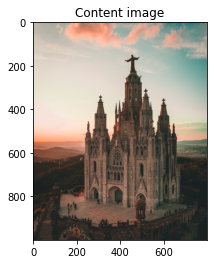

In [ ]:
content_img = Image.open(BytesIO(requests.get('https://images.unsplash.com/photo-1511527661048-7fe73d85e9a4').content))
# Resize image to 800 (width) x 1000 (height)
# Roughly preserves aspect ratio of original image
content_img = content_img.resize(size=(800,1000))
content_img.save('Content_img.png')
plt.imshow(content_img)
plt.title('Content image')
plt.show()

Load images to tensors, unsqueeze the first dimension (for batch_num).

In [ ]:
import torchvision
import numpy as np

# Set device for PyTorch (cpu or cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_to_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Note that ToTensor accepts both PIL images and numpy ndarrays
style_tensor = img_to_tensor(style_img).unsqueeze(0).to(device)
content_tensor = img_to_tensor(content_img).unsqueeze(0).to(device)

print(f'Style tensor dimensions: {style_tensor.size()}')
print(f'Content tensor dimensions: {content_tensor.size()}')

Style tensor dimensions: torch.Size([1, 3, 1000, 800])
Content tensor dimensions: torch.Size([1, 3, 1000, 800])


Create a model

In [ ]:
class custom_VGG(nn.Module):
    def __init__(self, requested_layers=[]):
        super().__init__()
        
        self.requested_layers = requested_layers
        
        # Include only the layers up to the one we need; we don't need any later layers
        self.model = torchvision.models.vgg16(pretrained=True).features[:25]

        self.outputs = {}

        def get_feature(layer_num):
            def hook(module, input, output):
                self.outputs[layer_num] = output
            return hook
    
        for layer_num, layer in enumerate(self.model):
            # Disable inplace operation for ReLU layers to help backpropagation
            # if isinstance(layer, nn.ReLU):
            #     layer.inplace = False         
            if layer_num in self.requested_layers:
                layer.register_forward_hook(get_feature(layer_num))
    
    def forward(self, x):
        self.model(x)
        return self.outputs

Create the training loop with custom loss functions

In [ ]:
# Set hyperparameters
total_steps = 100
learning_rate = 0.1
content_weight = 0.001
style_weight = 1.0

In [ ]:
# Choose the layers to use for style and content transfer
# In the paper, layers used are the convolutional layers that directly follow pooling.
# conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1
style_layers = [0, 5, 10, 17, 24]
# conv4_2
content_layers = [19]
# both style and content layers
generated_layers = [0, 5, 10, 17, 19, 24]

In [ ]:
# Custom function to transform a tensor to a Pillow image
toPIL = torchvision.transforms.ToPILImage()

In [ ]:
# Load the generated tensor, initializing from the content tensor
generated_tensor = content_tensor.clone().requires_grad_(True)

# Create a model object, use .eval() to tell PyTorch to handle BatchNorm and Dropout in evaluation (not training) mode
content_model = custom_VGG(requested_layers=generated_layers).to(device).eval()
style_model = custom_VGG(requested_layers=generated_layers).to(device).eval()
model = custom_VGG(requested_layers=generated_layers).to(device).eval()

# Set up the optimizer, based on the generated_tensor
optimizer = torch.optim.Adam([generated_tensor], lr=learning_rate)

# Ensure gradient info is not tracked for the content and style tensors
with torch.no_grad():
    content_features = content_model(content_tensor)
    style_features = style_model(style_tensor)

# Launch the progress bar
progress_bar = tqdm(total=total_steps)

for step in range(total_steps):
    # Reset the gradients
    optimizer.zero_grad()

    style_loss = 0
    content_loss = 0
    
    generated_features = model(generated_tensor)

    for layer in generated_layers:
        batch_size, channel, height, width = generated_features[layer].size()
        # Calculate the content loss
        if layer in content_layers:
            content_loss += torch.mean((generated_features[layer] - content_features[layer]) ** 2)
        # Calculate the style loss
        if layer in style_layers:
            # Gram matrix
            # The feature channels are matrix-multiplied (.mm) with a transposed version of themselves
            gen_gram_view = generated_features[layer].view(channel, height * width)
            style_gram_view = style_features[layer].view(channel, height * width)
            gen_gram = gen_gram_view.mm(gen_gram_view.t())
            style_gram = style_gram_view.mm(style_gram_view.t())
            style_loss += torch.mean((gen_gram - style_gram) ** 2)
    
    total_loss = (content_weight * content_loss) + (style_weight * style_loss)
    # Advance the counter
    # progress_bar.set_description(f'{step+1}/{total_steps}, Total loss: {total_loss.item():,.2f}')
    progress_bar.set_description(f'{step+1}/{total_steps}, Total loss: {total_loss.item():,.0f}, Content loss: {content_loss.item():,.0f}, Style loss: {style_loss.item():,.0f}')
    progress_bar.update(n=1)
    total_loss.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

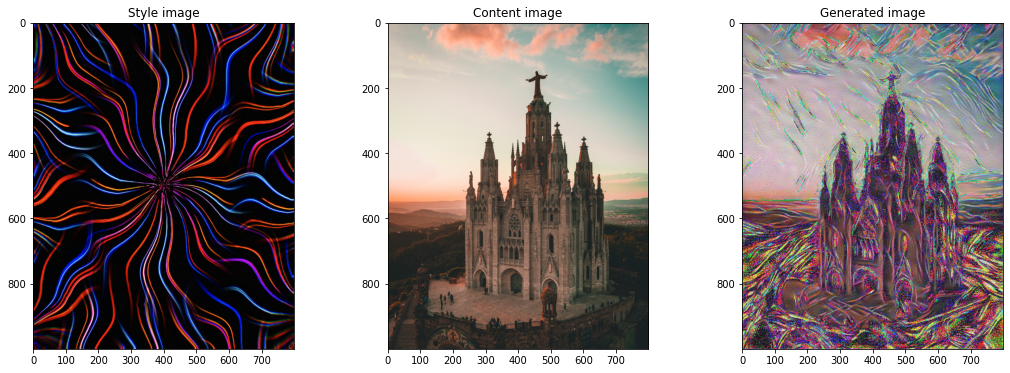

In [ ]:
# Show the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(style_img)
plt.title('Style image')

plt.subplot(1, 3, 2)
plt.imshow(content_img)
plt.title('Content image')

plt.subplot(1, 3, 3)
plt.imshow(toPIL(generated_tensor.detach().cpu().clone().squeeze(0)))
plt.title('Generated image')

plt.show()

# Lab 5: Style Transfer (Method 3)

## Objectives
* To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
* To understand the importance of a complex loss function.
* To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
# # Use this code to upload your own images

# load_and_normalize = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
# ])

# def upload():
#   print('Upload Content Image')
#   file_dict = files.upload()
#   content_path = io.BytesIO(file_dict[next(iter(file_dict))])

#   print('\nUpload Style Image')
#   file_dict = files.upload()
#   style_path = io.BytesIO(file_dict[next(iter(file_dict))])
#   return content_path, style_path

# content_path, style_path = upload()

# print("Content Path: {}".format(content_path))
# print("Style Path: {}".format(style_path))


In [ ]:
# # After the images are uploaded on to the local filesystem, you can use:
# content_image_orig = Image.open(content_path)
# content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
# style_image_orig = Image.open(style_path)
# style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

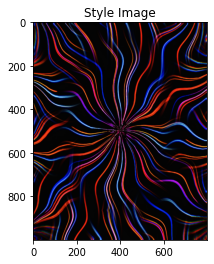

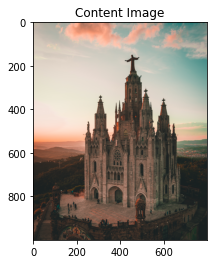

In [ ]:
# Display the images
toPIL = torchvision.transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_tensor, title='Style Image')

plt.figure()
display(content_tensor, title='Content Image')


___

## Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**

* ✅ Use the pretrained VGG in your model
* ✅ Gather statistics from the outputs of intermediate layers for the content image
* ✅ Gather statistics for the style image



In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
    def __init__(self, requested=[]):
        super().__init__()
        self.norm = Normalization().eval()
        self.intermediates = {}
        # Include only the layers up to the one we need (24)
        # This eliminates the fully-connected layers at the end,
        # which means the input size is unconstrained (conv layers don't
        # require a specific input size, only fully-connected ones do)
        self.vgg = torchvision.models.vgg16(pretrained=True).features[:25]

        def get_feature(layer_num):
            def hook(module, input, output):
                self.intermediates[layer_num] = output
            return hook

        for layer_num, layer in enumerate(self.vgg):
            # if isinstance(layer, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
            #     layer.inplace = False        # the model has a hard time going backwards on the in place functions.
            # Disable autograd since these layers have pre-trained weights
            # layer.requires_grad = False

            if layer_num in requested:
                layer.register_forward_hook(get_feature(layer_num))
    
    def forward(self, x):
        self.vgg(self.norm(x))  
        return self.intermediates

In [ ]:
# List the layers to be used for output capture
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1",
             "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1",
             "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1",
             "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3",
             "maxpool5"]
# Choose the layers to use for style and content transfer
# In the paper, layers used are the convolutional layers that directly follow pooling.
# conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1
style_layers = [0, 5, 10, 17, 24]
# conv4_2
content_layers = [19]
# both style and content layers
generated_layers = [0, 5, 10, 17, 19, 24]

# Set device for PyTorch (cpu or cuda (Nvidia GPU))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

style_tensor = style_tensor.to(device)
content_tensor = content_tensor.to(device)

# Create the vgg network in eval mode with our forward method that returns 
# the outputs of the intermediate layers we requested
with torch.no_grad():
    style_model = VGGIntermediate(requested=style_layers).to(device).eval()
    content_model = VGGIntermediate(requested=content_layers).to(device).eval()
    # Cache the outputs of the content and style layers for their respective images
    style_outputs = style_model(style_tensor)
    content_outputs = content_model(content_tensor)

___

## Part 2
Create classes for the style and content loss

**TODO:**

**DONE:**
* ✅ Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* ✅ Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [ ]:
def gram_matrix(input):
    # Input must be a Torch.Tensor object
    batch_num, channels, height, width = input.size()    
    # Size is (channels, height * width)
    gram_view = input.view(channels, height * width)

    # Matrix-multiply the tensor with itself (transposed)
    return gram_view.mm(gram_view.t())
  
class ContentLoss(nn.Module):
    def __init__(self, content_outputs):
        super().__init__()
        self.content_outputs = content_outputs
    
    def forward(self, predicted):
        loss = 0
        layer_weight = 1 / len(content_outputs)
        for key in predicted:
            if key in content_outputs:
                loss += layer_weight * torch.mean((predicted[key] - content_outputs[key]) ** 2)
        # Return the sum of squared differences
        return loss
    
class StyleLoss(nn.Module):
    def __init__(self, style_outputs):
        super().__init__()
        self.style_outputs = style_outputs
    
    def forward(self, predicted):
        loss = 0
        layer_weight = 1 / len(style_outputs)
        for key in predicted:
            if key in style_outputs:
                gram_predicted = gram_matrix(predicted[key])
                gram_truth = gram_matrix(style_outputs[key])
                loss += layer_weight * torch.mean((gram_predicted - gram_truth) ** 2)
        # Return the sum of squared differences
        return loss


# Instantiate a content loss module for each content layer with the content 
# reference image outputs for that layer for comparison
content_loss = ContentLoss(content_outputs)

# Instantiate a style loss module for each style layer with the style 
# reference image outputs for that layer for comparison
style_loss = StyleLoss(style_outputs)

___

## Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

❔ Note that the content loss should be zero if you take out the style loss. Why is that?

**ANSWER:** Because the generated image starts out as an exact replica of the content image, so there are no differences (hence, no loss) between the content image and the generated image.

**TODO:**
* Display the tensor as an image!

**DONE:**
* ✅ Use an Adam optimizer (try learning rate of .1)
* ✅ Show both the content and the style loss every 50 steps
* ✅ Ensure that the outputs don't go out of range (clamp them)



  0%|          | 0/50 [00:00<?, ?it/s]

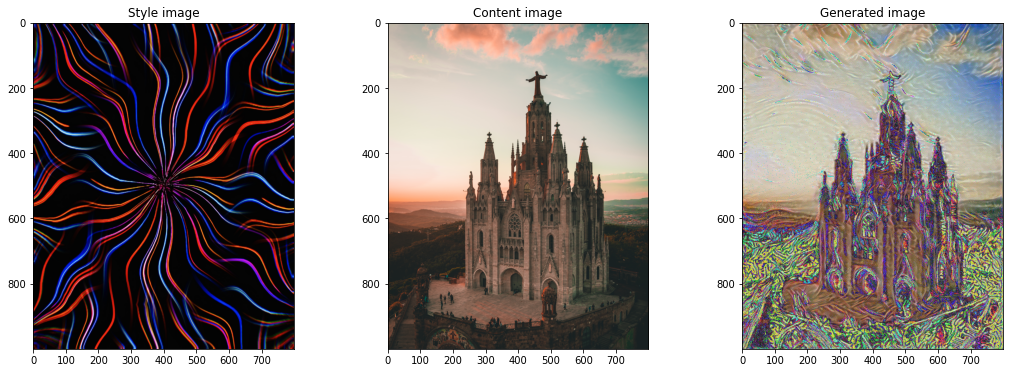

In [ ]:
# Start with a copy of the content image
total_steps = 50
learning_rate = 0.1
content_weight = 0.001
style_weight = 1.0

# Initialize the generated image by starting from the content image
generated_tensor = content_tensor.clone().to(device)            # .clamp(min=0, max=1)
# Make sure that the generated image can be updated through backpropagation
generated_tensor.requires_grad = True

generated_model = VGGIntermediate(requested=generated_layers).to(device).eval()
optimizer = torch.optim.Adam([generated_tensor], lr=learning_rate)

progress_bar = tqdm(total=total_steps)

# Run the optimizer on the images to change the image using the loss of the
# style and content layers to backpropagate errors
for step in range(total_steps):
    # Clear out gradient info
    optimizer.zero_grad()
    
    generated_outputs = generated_model(generated_tensor)

    # Calculate loss
    c_loss = content_loss(generated_outputs)
    s_loss = style_loss(generated_outputs)
    total_loss = (content_weight * c_loss) + (style_weight * s_loss)
    
    # Advance the counter
    # progress_bar.set_description(f'{step+1}/{total_steps}, Total loss: {total_loss.item():,.0f}')
    progress_bar.set_description(f'{step}/{total_steps}, Total loss: {total_loss.item():,.0f}, Content loss: {c_loss.item():,.0f}, Style loss: {s_loss.item():,.0f}')
    progress_bar.update(n=1)
    
    # Backpropagate the error
    total_loss.backward()
    
    # Take a step
    optimizer.step()

# Show the image
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(style_img)
plt.title('Style image')

plt.subplot(1, 3, 2)
plt.imshow(content_img)
plt.title('Content image')

plt.subplot(1, 3, 3)
plt.imshow(toPIL(generated_tensor.detach().cpu().clone().squeeze(0)))
plt.title('Generated image')

plt.show()

## Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

### Explanation of equations

### Eq. 1 (p. 10)
The content loss function. This is the sum of the squared differences between the feature map(s) at specified layer(s) for the generated and content images.

Meaning of inputs: $p$ is the content image, $x$ is the generated image, $l$ is the given layer (e.g., conv4_2), and $F$ is the output (feature map) from the generated image at layer $l$, and $P$ is the output (feature map) from the content image at layer $l$.

### Eq. 3 (p. 11)
The computation of a gram matrix, which is the sum of pairwise multiplication of every channel (feature map) at a given layer.

### Eq. 4 (p. 11)
The style loss, or the sum of squared differences between the gram matrix for the style image and the generated image.


### Eq. 5 (p. 11)
The weight assigned to the style loss multiplied by the style loss.